In [4]:
import numpy as np
import sympy as sp
from tqdm import tqdm

from kan import *  # Ensure that 'pykan' is installed or available in your PYTHONPATH

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
import torch
import torch.nn as nn
import torch.autograd as autograd


# Define a function that builds the gradient network in a differentiable manner
class GradNetwork(nn.Module):
    def __init__(self, base_network):
        super(GradNetwork, self).__init__()
        self.base_network = base_network

    def forward(self, x, idx=0):
        # Compute the output of the original network
        output = self.base_network(x)
        
        # Compute the gradient of the output with respect to input feature x[idx]
        grad_outputs = torch.ones_like(output)
        gradient = autograd.grad(
            outputs=output,
            inputs=x,
            grad_outputs=grad_outputs,
            create_graph=True,  # Important for allowing second-order gradients
            retain_graph=True  # Keep graph for further operations
        )[0]
        
        # Extract the gradient with respect to the specified dimension
        grad_i = gradient[:, idx].unsqueeze(1)  # Assuming batch size and extracting the i-th dimension
        
        return grad_i

# Instantiate the integral network as a simple KAN with 3 hidden neurons 
int_network = KAN(width=[1,3,1], grid=3, k=3, seed=1, device=device)

# Instantiate the gradient network
grad_network = GradNetwork(int_network)


checkpoint directory created: ./model
saving model version 0.0


In [6]:
# Define the true function we want to fit the gradient network to (this is the INTEGRAND)
def true_function(x):
    return torch.sin(x)**2

In [8]:
import torch.optim as optim

# Create a dataset to fit
x_train = torch.linspace(-3, 3, 1000).unsqueeze(1)  # 100 points from -5 to 5
true_grad =  true_function(x_train)

# Set up the optimizer and loss function
optimizer = optim.Adam(grad_network.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass through grad network
    x_train.requires_grad_(True)
    grad_output = grad_network(x_train)
    
    # Compute loss
    loss = criterion(grad_output, true_grad)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Print loss occasionally
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')



Epoch [100/1000], Loss: 0.0043
Epoch [200/1000], Loss: 0.0027
Epoch [300/1000], Loss: 0.0017
Epoch [400/1000], Loss: 0.0008
Epoch [500/1000], Loss: 0.0003
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


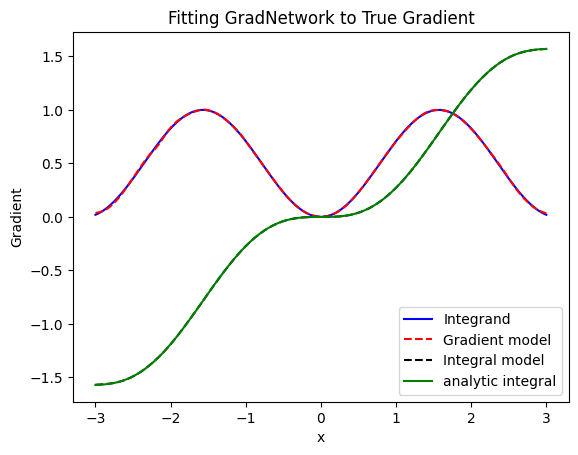

In [14]:
# Plot the results
x_test = torch.linspace(-3, 3, 100).unsqueeze(1)
x_test.requires_grad_(True)
grad_output_test = grad_network(x_test).detach()
model_output_test = int_network(x_test).detach()-int_network(torch.tensor([[0.]]))

#analytic integral of sin(x)^2
x=x_test.detach()
y = x / 2 - (1/4) * np.sin(2 * x)


plt.plot(x_train.detach().numpy(), true_grad.detach().numpy(), label='Integrand', color='blue')
plt.plot(x_test.detach().numpy(), grad_output_test.detach().numpy(), label='Gradient model', color='red', linestyle='dashed')
plt.plot(x_test.detach().numpy(), model_output_test.detach().numpy(), label='Integral model', color='black', linestyle='dashed')
plt.plot(x, y, label='analytic integral', color='green')
plt.xlabel('x')
plt.ylabel('Gradient')
plt.legend()
plt.title('Fitting GradNetwork to True Gradient')
plt.show()